In [1]:
import numpy as np
import pandas as pd
import random
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
import pickle
from collections import defaultdict
import scipy

from exp3_utils import *
from language_models import *

/home/15171531/miniconda3/envs/analysis_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
w2v2_path_audio = 'embeddings/wav2vec2/LibriSpeech_audioslicing/w2v2_LibriSpeech_audioslicing.pkl' 

fast_vgs_plus_path_audio = 'embeddings/fast_vgs/LibriSpeech_audioslicing/fast_vgs_plus_librispeech_audioslicing.pkl'

w2v2_path_feat = 'embeddings/wav2vec2/LibriSpeech_featureslicing/w2v2_LibriSpeech_featureslicing.pkl'

fast_vgs_plus_path_feat = 'embeddings/fast_vgs/LibriSpeech_featureslicing/fast_vgs_plus_LibriSpeech_featureslicing.pkl'

glove_path = 'exp1_data/'

data_path = 'exp3/' # TODO: set path

figure_path = 'exp3/figures/'

In [7]:
df_w2v2_audio_slice = pickle.load(open(w2v2_path_audio, "rb"))
df_fast_vgs_plus_audio_slice = pickle.load(open(fast_vgs_plus_path_audio, "rb"))

#df_w2v2_feat_slice = pickle.load(open(w2v2_path_feat, "rb"))
#df_fast_vgs_plus_feat_slice = pickle.load(open(fast_vgs_plus_path_feat, "rb"))

/tmp/ipykernel_2092440/246140594.py:1: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  df_w2v2_audio_slice = pickle.load(open(w2v2_path_audio, "rb"))
/tmp/ipykernel_2092440/246140594.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the

In [11]:
glove_embeddings = {}
with open(glove_path + 'glove.6B.300d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        split_line = line.strip().split()
        word = split_line[0]
        embedding = np.array(list(map(float, split_line[1:])))
        glove_embeddings[word] = embedding

In [12]:
# filter speech datasets
df_w2v2_audioslice = df_w2v2_audio_slice[df_w2v2_audio_slice['text'].isin(glove_embeddings.keys())]

df_fast_vgs_plus_audio_slice = df_fast_vgs_plus_audio_slice[df_fast_vgs_plus_audio_slice['text'].isin(glove_embeddings.keys())]

#df_w2v2_feat_slice = df_w2v2_feat_slice[df_w2v2_feat_slice['text'].isin(glove_embeddings.keys())]

#df_fast_vgs_plus_feat_slice = df_fast_vgs_plus_feat_slice[df_fast_vgs_plus_feat_slice['text'].isin(glove_embeddings.keys())]

In [13]:
reg_bert = load_pretrained_bert_model(pretr_type='bert-base-uncased', output_hidden=True, device='cpu')
vg_bert = load_pretrained_vg_bert_model(checkpoint_path='vg_bert_best_model.pth', device='cpu', output_hidden=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/home/15171531/miniconda3/envs/analysis_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/15171531/miniconda3/envs/analysis_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/15171531/language_models.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/p

In [ ]:
indices = random.sample(range(len(df_w2v2_audioslice)), 10000)

glove_embds = np.stack([glove_embeddings[word] for word in df_w2v2_audioslice.iloc[indices]['text'].values])
print(f'Got glove embeddings')
bert_embds = [get_layerwise_embeddings(reg_bert, tokenizer, word, device='cpu') for word in df_w2v2_audioslice.iloc[indices]['text'].values]
print(f'Got BERT embeddings')
vg_bert_embds = [get_layerwise_embeddings(vg_bert, tokenizer, word, device='cpu') for word in df_w2v2_audioslice.iloc[indices]['text'].values]
print(f'Got VG-BERT embeddings')

layer_dists_w2v2_glove_audio = []
layer_dists_w2v2_bert_audio = []
layer_dists_w2v2_vgbert_audio = []

layer_dists_w2v2_glove_feat = []
layer_dists_w2v2_bert_feat = []
layer_dists_w2v2_vgbert_feat = []

layer_dists_fast_vgs_plus_glove_audio = []
layer_dists_fast_vgs_plus_bert_audio = []
layer_dists_fast_vgs_plus_vgbert_audio = []

layer_dists_fast_vgs_plus_glove_feat = []
layer_dists_fast_vgs_plus_bert_feat = []
layer_dists_fast_vgs_plus_vgbert_feat = []

Got glove embeddings
Got BERT embeddings
Got VG-BERT embeddings


In [15]:
for layer_idx in range(12):
    print(f'Layer {layer_idx}')
    layer = f'layer_{layer_idx}'

    ### Audio slicing ###
    df_subset_audioslice_w2v2 = df_w2v2_audioslice.iloc[indices]
    w2v2_audioslice_embds = np.stack(df_subset_audioslice_w2v2['w2v2_embeddings'].apply(lambda x: x[layer]).values)

    df_subset_audioslice_fast_vgs_plus = df_fast_vgs_plus_audio_slice.iloc[indices]
    fast_vgs_plus_audioslice_embds = np.stack(df_subset_audioslice_fast_vgs_plus['fast_vgs_plus_embeddings'].apply(lambda x: x[layer]).values)

    ### Feature slicing ###
    #df_subset_featslice_w2v2 = df_w2v2_feat_slice.iloc[indices]
    #w2v2_featslice_embds = np.stack(df_subset_featslice_w2v2['w2v2_embeddings'].apply(lambda x: x[layer]).values)

    #df_subset_featslice_fast_vgs_plus = df_fast_vgs_plus_feat_slice.iloc[indices]
    #fast_vgs_plus_featslice_embds = np.stack(df_subset_featslice_fast_vgs_plus['fast_vgs_plus_embeddings'].apply(lambda x: x[layer]).values)

    bert_layer_embds = np.stack([bert_embds[i][layer] for i in range(len(bert_embds))])

    vg_bert_layer_embds = np.stack([vg_bert_embds[i][layer] for i in range(len(vg_bert_embds))])

    layer_dists_w2v2_glove_audio.append(compute_model_layer_cka(w2v2_audioslice_embds, glove_embds))
    layer_dists_w2v2_bert_audio.append(compute_model_layer_cka(w2v2_audioslice_embds, bert_layer_embds))
    layer_dists_w2v2_vgbert_audio.append(compute_model_layer_cka(w2v2_audioslice_embds, vg_bert_layer_embds))

    #layer_dists_w2v2_glove_feat.append(compute_model_layer_cka(w2v2_featslice_embds, glove_embds))
    #layer_dists_w2v2_bert_feat.append(compute_model_layer_cka(w2v2_featslice_embds, bert_layer_embds))
    #layer_dists_w2v2_vgbert_feat.append(compute_model_layer_cka(w2v2_featslice_embds, vg_bert_layer_embds))

    layer_dists_fast_vgs_plus_glove_audio.append(compute_model_layer_cka(fast_vgs_plus_audioslice_embds, glove_embds))
    layer_dists_fast_vgs_plus_bert_audio.append(compute_model_layer_cka(fast_vgs_plus_audioslice_embds, bert_layer_embds))
    layer_dists_fast_vgs_plus_vgbert_audio.append(compute_model_layer_cka(fast_vgs_plus_audioslice_embds, vg_bert_layer_embds))

    #layer_dists_fast_vgs_plus_glove_feat.append(compute_model_layer_cka(fast_vgs_plus_featslice_embds, glove_embds))
    #layer_dists_fast_vgs_plus_bert_feat.append(compute_model_layer_cka(fast_vgs_plus_featslice_embds, bert_layer_embds))
    #layer_dists_fast_vgs_plus_vgbert_feat.append(compute_model_layer_cka(fast_vgs_plus_featslice_embds, vg_bert_layer_embds))

Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11


In [ ]:
agg_dists_feat = {
    'Wav2Vec2': {
        'glove': layer_dists_w2v2_glove_feat,
        'bert': layer_dists_w2v2_bert_feat,
        'vgbert': layer_dists_w2v2_vgbert_feat,
    },
    'FaST-VGS+': {
        'glove': layer_dists_fast_vgs_plus_glove_feat,
        'bert': layer_dists_fast_vgs_plus_bert_feat,
        'vgbert': layer_dists_fast_vgs_plus_vgbert_feat,
    }
}

agg_dists_audio = {
    'Wav2Vec2': {
        'glove': layer_dists_w2v2_glove_audio,
        'bert': layer_dists_w2v2_bert_audio,
        'vgbert': layer_dists_w2v2_vgbert_audio,
    },
    'FaST-VGS+': {
        'glove': layer_dists_fast_vgs_plus_glove_audio,
        'bert': layer_dists_fast_vgs_plus_bert_audio,
        'vgbert': layer_dists_fast_vgs_plus_vgbert_audio,
    }
}

with open(f'{data_path}agg_dists_audio.pkl', 'wb') as f:
    pickle.dump(agg_dists_audio, f)

In [4]:
with open(f'{data_path}agg_dists_audio.pkl', 'rb') as f:
    agg_dists_audio = pickle.load(f)

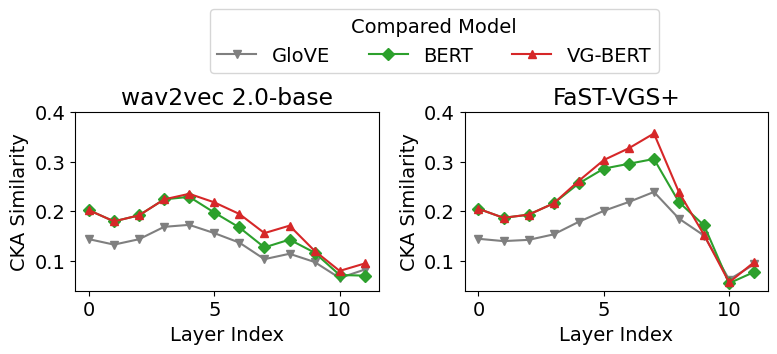

In [18]:
keys = {
    "glove": ("C7", "v", "GloVE"),
    "bert": ("C2", "D", "BERT"),
    "vgbert": ("C3", "^", "VG-BERT"),
}
for slicing in ['audio']:
    if slicing == 'audio':
        agg_dists = agg_dists_audio
    else:
        agg_dists = agg_dists_feat
    fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
    for loc, ax, title, model in zip(("left", "right"), axes, ["wav2vec 2.0-base", "FaST-VGS+"], ["Wav2Vec2", "FaST-VGS+"]):
        for key, tuples in agg_dists[model].items():
            #print(key)
            value = tuples
            color, marker, label = keys[key]
            style = "solid"
            ax.plot(value, label=label, marker=marker, color=color, linestyle=style)

        ax.set_yticks([0.1, 0.2, 0.3, 0.4])
        ax.yaxis.set_tick_params(labelbottom=True)
        ax.set_xticks([0, 5, 10])
        ax.set_title(title)
        ax.set_ylabel("CKA Similarity")
        ax.set_xlabel("Layer Index")
    plt.tight_layout()
    plt.legend(loc="center", bbox_to_anchor= (-0.1, 1.4), ncols= 3, title = 'Compared Model')
    plt.savefig(f"{figure_path}CKA_Analysis_{slicing}_FINAL.pdf", bbox_inches="tight")
    plt.show()